# Solving a simple boundary integral equation - a strike slip underneath topography.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from common import gauss_rule, double_layer_matrix, qbx_choose_centers, qbx_expand_matrix, qbx_eval_matrix

In [2]:
import sympy as sp

In [3]:
fault_depth = 0.5
def fault_fnc(q):
    return 0*q, q - 1 - fault_depth, -np.ones_like(q), 0*q, 1.0

In [4]:
surf_L = 10
def flat_fnc(q):
    return surf_L*q, 0*q, 0*q, np.ones_like(q), surf_L

In [5]:
def slip_fnc(xhat):
    # This must be zero at the endpoints!
    return np.where(
        xhat < -0.9, 
        (1.0 + xhat) * 10,
        np.where(xhat < 0.9, 
                 1.0,
                 (1.0 - xhat) * 10
                )
    )

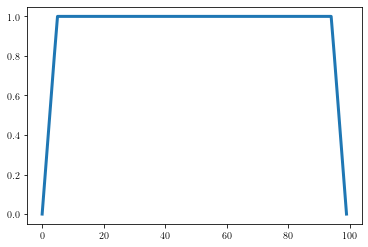

In [6]:
plt.plot(slip_fnc(np.linspace(-1, 1, 100)))

In [7]:
qr_fault = gauss_rule(50)
fault = fault_fnc(qr_fault[0])

In [8]:
qr_flat = gauss_rule(500)
flat = flat_fnc(qr_flat[0])

In [9]:
qbx_p = 5
qbx_center_x, qbx_center_y, qbx_r = qbx_choose_centers(flat, qr_flat)
qbx_expand_flat = qbx_expand_matrix(double_layer_matrix, flat, qr_flat, qbx_center_x, qbx_center_y, qbx_r, qbx_p=qbx_p)
qbx_eval_flat = qbx_eval_matrix(flat[0][None,:], flat[1][None,:], qbx_center_x, qbx_center_y, qbx_p=qbx_p)[0]
A = np.real(np.sum(qbx_eval_flat[:,:,None] * qbx_expand_flat, axis=1))

In [10]:
B = double_layer_matrix(fault, qr_fault, flat[0], flat[1])
slip = slip_fnc(qr_fault[0])
v = B.dot(slip)

In [11]:
surf_disp = np.linalg.solve(A - 0.5 * np.eye(A.shape[0]), v)

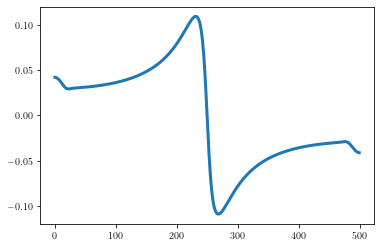

In [12]:
plt.plot(surf_disp)
plt.show()

In [13]:
nobs = 100
zoomx = [-2.5, 2.5]
zoomy = [-4.5, 0.5]
# zoomx = [-25, 25]
# zoomy = [-45, 5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

In [14]:
disp_flat = double_layer_matrix(
    surface   = flat,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = qr_flat
).dot(surf_disp).reshape(obsx.shape)
disp_fault = double_layer_matrix(
    surface   = fault,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = qr_fault
).dot(slip).reshape(obsx.shape)
disp_full = disp_flat + disp_fault

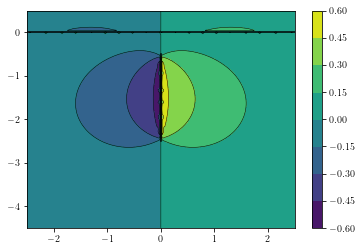

In [15]:
levels = np.linspace(-1.0,1.0,11)
cntf = plt.contourf(obsx, obsy, disp_full)#, levels = levels, extend="both")
plt.contour(obsx, obsy, disp_full, colors='k', linestyles='-', linewidths=0.5)#, levels = levels, extend="both")
plt.plot(flat[0], flat[1], 'k-', linewidth=1.5)
plt.plot(fault[0], fault[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

In [27]:
def symbolic_surface(t, x, y):
    dxdt = sp.diff(x, t)
    dydt = sp.diff(y, t)

    ddt_norm = sp.simplify(sp.sqrt(dxdt ** 2 + dydt ** 2))
    dxdt /= ddt_norm
    dydt /= ddt_norm
    
    return x, y, dydt, -dxdt, ddt_norm

def symbolic_eval(t, tvals, exprs):
    out = []
    for e in exprs:
        out.append(sp.lambdify(t, e, "numpy")(tvals))
    return out

sym_t = sp.symbols('t')
sym_x = surf_L*sym_t
sym_y = sp.exp(-sym_t**2 * 50) * sp.Rational(1.5) - sp.Rational(1.5)
sym_topo = symbolic_surface(sym_t, sym_x, sym_y)

qr_topo = gauss_rule(800)
topo = symbolic_eval(sym_t, qr_topo[0], sym_topo)

In [28]:
sp.Eq(sp.var('\\vec{n}'), sp.Tuple(sym_topo[2], sym_topo[3]))

Eq(\vec{n}, (-15*t*exp(-50*t**2)/sqrt(225*t**2*exp(-100*t**2) + 1), -1/sqrt(225*t**2*exp(-100*t**2) + 1)))

(-2.5, 2.5)

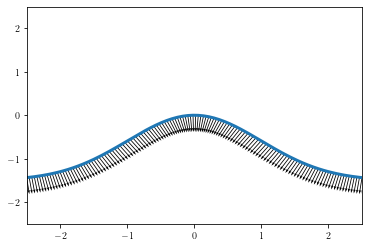

In [31]:
plt.plot(topo[0], topo[1])
plt.quiver(topo[0], topo[1], topo[2], topo[3], scale = 20)
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])

In [30]:
def self_interaction_matrix(kernel, surface, quad_rule, qbx_p = 5):
    qbx_center_x, qbx_center_y, qbx_r = qbx_choose_centers(surface, quad_rule)
    qbx_expand = qbx_expand_matrix(kernel, surface, quad_rule, qbx_center_x, qbx_center_y, qbx_r, qbx_p=qbx_p)
    qbx_eval = qbx_eval_matrix(surface[0][None,:], surface[1][None,:], qbx_center_x, qbx_center_y, qbx_p=qbx_p)[0]
    return np.real(np.sum(qbx_eval[:,:,None] * qbx_expand, axis=1))

In [32]:
A = self_interaction_matrix(double_layer_matrix, topo, qr_topo)
B = double_layer_matrix(fault, qr_fault, topo[0], topo[1])
slip = slip_fnc(qr_fault[0])
v = B.dot(slip)
surf_disp = np.linalg.solve(A - 0.5 * np.eye(A.shape[0]), v)

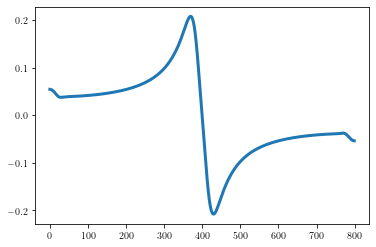

In [33]:
plt.plot(surf_disp)
plt.show()

In [34]:
nobs = 400
zoomx = [-2.5, 2.5]
zoomy = [-4.5, 1.5]
# zoomx = [-25, 25]
# zoomy = [-45, 5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

In [35]:
disp_topo = double_layer_matrix(
    surface   = topo,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = qr_topo
).dot(surf_disp).reshape(obsx.shape)
disp_fault = double_layer_matrix(
    surface   = fault,
    obsx      = obsx.flatten(), 
    obsy      = obsy.flatten(),
    quad_rule = qr_fault
).dot(slip).reshape(obsx.shape)

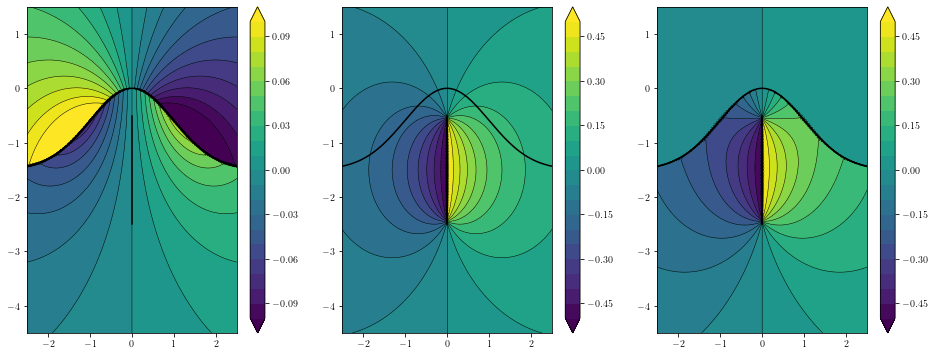

In [36]:
plt.figure(figsize = (16,6))
plt.subplot(1,3,1)
levels = np.linspace(-0.1,0.1,21)
cntf = plt.contourf(obsx, obsy, disp_topo, levels = levels, extend="both")
plt.contour(obsx, obsy, disp_topo, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
plt.plot(topo[0], topo[1], 'k-', linewidth=1.5)
plt.plot(fault[0], fault[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,3,2)
levels = np.linspace(-0.5,0.5,21)
cntf = plt.contourf(obsx, obsy, disp_fault, levels = levels, extend="both")
plt.contour(obsx, obsy, disp_fault, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
plt.plot(topo[0], topo[1], 'k-', linewidth=1.5)
plt.plot(fault[0], fault[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(1,3,3)
levels = np.linspace(-0.5,0.5,21)
cntf = plt.contourf(obsx, obsy, disp_topo + disp_fault, levels = levels, extend="both")
plt.contour(obsx, obsy, disp_topo + disp_fault, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
plt.plot(topo[0], topo[1], 'k-', linewidth=1.5)
plt.plot(fault[0], fault[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.show()